Business case:
- Consulting Apple and Google on most loved things (product, service, app, etc) for them to invest in promotion of based on SXSW tweets

**AVOID FALSE POSITIVE - MAXIMIZE PRECISION**
- False Positive: a negative or neutral tweet is classified as positive and company invests in promoting something that customers view negatively
    - False Positive is worse of the two because it leads to negative customer experience, lower NPS, and brand suffers in longer term. Basically spending money for customer to have negative experience.
- False Negative: a positive tweet is classified as negative, and company misses opportunity to invest in promoting something that customers view positively

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re #regex
import nltk
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec

# Tweet preprocessor - Source: https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
import preprocessor as p

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import string

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, f1_score

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [896]:
# Import file
raw_data = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')
df = raw_data.copy()

# Preview file 
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [897]:
# Overview file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [898]:
# Fill nulls
df['emotion_in_tweet_is_directed_at'].fillna('None', inplace=True)

In [899]:
# drop row 6, tweet_text null row; 9092 row is foreign characters
df.drop(labels=[6, 9092], axis=0, inplace=True)

# reset index post drop
df = df.reset_index(drop=True)

In [900]:
# Value counts exploration
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5387
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [901]:
# Filter down emotions to Neutral
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"No emotion toward brand or product" : "Neutral",
                                                                                                                         "Positive emotion": "Positive",
                                                                                                                         "Negative emotion": "Negative",
                                                                                                                         "I can't tell": "Neutral"})

In [902]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Neutral     5543
Positive    2978
Negative     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [903]:
# Create target; Positive only - 32%
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"Positive": 1,
                                                                             "Neutral": 0,
                                                                             "Negative": 0})

In [904]:
# Check work
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 4 columns):
tweet_text                                            9091 non-null object
emotion_in_tweet_is_directed_at                       9091 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9091 non-null object
target                                                9091 non-null int64
dtypes: int64(1), object(3)
memory usage: 284.2+ KB


### Processing Tweets

In [905]:
# Createw new column for cleaned tweet text
df['clean_tweet'] = df['tweet_text'].copy()

#### Replace hashtags, links, rts, and mentions

In [906]:
# Using placeholder(ph) because if use {hashtag}, 
# tokenizing will be wrong, separates first { then rest of string

# Replace hashtags with placeholder(HASHPH)
df['clean_tweet'] = df['clean_tweet'].replace({'#':'hashph'}, regex=True)

# Replace links with placeholder(LINKPH)
df['clean_tweet'] = df['clean_tweet'].replace({'http':'linkph',
                                              '{link}':'linkph'}, regex=True)

# Replace RT with placeholder(RTPH)
df['clean_tweet'] = df['clean_tweet'].replace({'RT':'rtph'}, regex=True)
# Did not account for rt (stand alone string)

# Replace mentions with placeholder(MENPH)
df['clean_tweet'] = df['clean_tweet'].replace({'@mention':'menph'}, regex=True)
# Account for mentions that do not have '@mention' in the original text and have usernames
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'@\w+', 'menph', (x)))

In [1098]:
len(df[df['clean_tweet'].str.contains('hashph')])
# Almost all contain hashtags

9085

In [908]:
len(df[df['clean_tweet'].str.contains('linkph')])
# 51% contain links

4193

In [909]:
len(df[df['clean_tweet'].str.contains('rtph')])
# 29% contain RTs (systematic, lowercase rts not accounted for)

2686

In [910]:
len(df[df['clean_tweet'].str.contains('linkph')])
# 51% contain links

4193

In [911]:
len(df[df['clean_tweet'].str.contains('menph')])
# 54% contain mentions

4918

#### Cleaning html, removing punctuation, lowercasing

In [912]:
# Clean 'clean_tweet' column of HTML; there were things like &quot
html_ent_clean = re.compile('&.*?;')
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(html_ent_clean, '',x))

# Remove punctuation
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', (x)))

# Source: https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

In [913]:
# Preview clean text column, sanity check
df['clean_tweet']

0       menph I have a 3G iPhone After 3 hrs tweeting ...
1       menph Know about menph  Awesome iPadiPhone app...
2       menph Can not wait for hashphiPad 2 also They ...
3       menph I hope this years festival isnt as crash...
4       menph great stuff on Fri hashphSXSW Marissa Ma...
                              ...                        
9086    menph Yup but I dont have a third app yet Im o...
9087                    Ipad everywhere hashphSXSW linkph
9088    Wave buzz rtph menph We interrupt your regular...
9089    Googles Zeiger a physician never reported pote...
9090    Some Verizon iPhone customers complained their...
Name: clean_tweet, Length: 9091, dtype: object

In [914]:
# Source: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [915]:
# Remove spacy stopwords
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join(
    [word for word in x.split() if word.lower() not in (stop_words)]))

In [916]:
# Lowercase text
df['clean_tweet'] = df['clean_tweet'].str.lower()

In [917]:
# Create new column for tokenized tweets
df['token_tweet'] = ""

In [918]:
# Create function to tokenize with spacy

def tokenize_tweet(tweet):
    my_tweet = nlp(tweet) 
    token_list = []
    for token in my_tweet:
        token_list.append(token.text)
    return token_list

In [919]:
# Create token tweet values
df['token_tweet'] = df['clean_tweet'].apply(tokenize_tweet)

In [920]:
# Preview new column
df['token_tweet']

0       [menph, 3, g, iphone, 3, hrs, tweeting, hashph...
1       [menph, know, menph, awesome, ipadiphone, app,...
2          [menph, wait, hashphipad, 2, sale, hashphsxsw]
3       [menph, hope, years, festival, is, nt, crashy,...
4       [menph, great, stuff, fri, hashphsxsw, marissa...
                              ...                        
9086    [menph, yup, do, nt, app, i, m, android, sugge...
9087                           [ipad, hashphsxsw, linkph]
9088    [wave, buzz, rtph, menph, interrupt, regularly...
9089    [googles, zeiger, physician, reported, potenti...
9090    [verizon, iphone, customers, complained, time,...
Name: token_tweet, Length: 9091, dtype: object

In [921]:
# Review df overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 6 columns):
tweet_text                                            9091 non-null object
emotion_in_tweet_is_directed_at                       9091 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9091 non-null object
target                                                9091 non-null int64
clean_tweet                                           9091 non-null object
token_tweet                                           9091 non-null object
dtypes: int64(1), object(5)
memory usage: 426.3+ KB


In [922]:
# Lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

df['token_tweet'] = df['token_tweet'].apply(lemmatize_text)

# Rejoin in new column
df['clean_token_tweet'] = df['token_tweet'].map(lambda x: ' '.join(x))

# Source: https://stackoverflow.com/questions/59567357/lemmatize-tokenised-column-in-pandas

In [923]:
# Preview new column 
df['clean_token_tweet']

0       menph 3 g iphone 3 hr tweeting hashphrise_aust...
1       menph know menph awesome ipadiphone app you ll...
2                 menph wait hashphipad 2 sale hashphsxsw
3       menph hope year festival is nt crashy year iph...
4       menph great stuff fri hashphsxsw marissa mayer...
                              ...                        
9086    menph yup do nt app i m android suggestion has...
9087                               ipad hashphsxsw linkph
9088    wave buzz rtph menph interrupt regularly sched...
9089    google zeiger physician reported potential ae ...
9090    verizon iphone customer complained time fell h...
Name: clean_token_tweet, Length: 9091, dtype: object

In [924]:
# Review df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 7 columns):
tweet_text                                            9091 non-null object
emotion_in_tweet_is_directed_at                       9091 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9091 non-null object
target                                                9091 non-null int64
clean_tweet                                           9091 non-null object
token_tweet                                           9091 non-null object
clean_token_tweet                                     9091 non-null object
dtypes: int64(1), object(6)
memory usage: 497.3+ KB


#### Skimming unique tokens of positive versus neutral/negative tweets

In [925]:
positive_tweet_text = df[df['target'] == 1]['token_tweet']
neut_neg_tweet_text = df[df['target'] == 0]['token_tweet']

In [2]:
from wordcloud import WordCloud

In [ ]:
wordcloud = WordCloud().generate(' '.join(df['clean_text']))
# Generate plot
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
# Looks like there may be imbalance in brand represenation
#Source: https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe

In [926]:
pos_token_list = []

for tweet in positive_tweet_text:
    for token in tweet:
        pos_token_list.append(token)
        
pos_token_list_set = set(pos_token_list)
        
len(set(pos_token_list))

5042

In [927]:
neut_neg_token_list = []

for tweet in neut_neg_tweet_text:
    for token in tweet:
        neut_neg_token_list.append(token)
        
len(set(neut_neg_token_list))

8069

In [928]:
neut_neg_token_list_set = set(neut_neg_token_list)

In [929]:
pos_token_list_unique = pos_token_list_set.difference(neut_neg_token_list_set)
# new set with elements in pos_token_list_set but not in neut_neg_token_list_set
len(pos_token_list_unique)

1861

In [931]:
neut_neg_token_list_unique = neut_neg_token_list_set.difference(pos_token_list_set)
# new set with elements in neut_neg_token_list_set but not in pos_token_list_set
len(neut_neg_token_list_unique)
# 2.5x the number of unique tokens for neut_neg tweets
# 27% of unique tokens are positive (less than 67/33 split of tweets)

4888

### From notebook 3

### NB + CountVec

In [963]:
# Grabbing our inputs and target
X = df['clean_tweet']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Accuracy:0.7175538935327761
Precision:0.5896607431340872
Precision Mean Cross Val 3-Fold: 0.5474140331207468
F1 Score:0.532069970845481


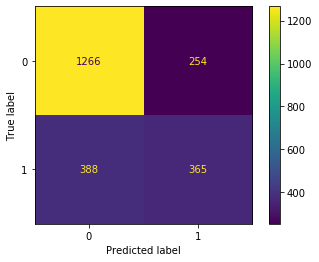

In [1003]:
# Instantiating a count vectorizer
countvec = CountVectorizer()

# Trying Naive Bayes
nb = MultinomialNB()

X_train_transformed = countvec.fit_transform(X_train) #learning corpus of training data (holistic)
X_test_transformed = countvec.transform(X_test) # new words only in test set won't impact

nb.fit(X_train_transformed, y_train)

train_preds = nb.predict(X_train_transformed)
test_preds = nb.predict(X_test_transformed)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(nb,  X_train_transformed, y_train, cv=3, scoring='precision'))}")
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb, X_test_transformed, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

### NB + TF-IDF

In [979]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Trying Naive Bayes
nb2 = MultinomialNB()

In [1100]:
tfidf.vocabulary_  #hotspot?

{'hotpot': 2366,
 'hashphgoogle': 1916,
 'hashphmarissameyer': 2010,
 'hashphclevelandsteamer': 1828,
 'days': 1024,
 'closer': 790,
 'owner': 3147,
 'ipad': 2516,
 'stoked': 4006,
 'thing': 4195,
 'getting': 1606,
 'rtph': 3651,
 'menph': 2888,
 'line': 2711,
 'apple': 312,
 'store': 4014,
 'demo': 1065,
 'units': 4363,
 '5pm': 127,
 'hashphfb': 1891,
 'linkph': 2719,
 'listening': 2727,
 'google': 1643,
 'qa': 3449,
 'saying': 3696,
 'yelp': 4633,
 'services': 3767,
 'going': 1633,
 'die': 1105,
 'far': 1408,
 'interesting': 2487,
 'theyre': 4191,
 'im': 2412,
 'developer': 1095,
 'awesome': 402,
 'event': 1333,
 'join': 2573,
 'league': 2667,
 'extraordinary': 1381,
 'hashphh4ckers': 1931,
 'able': 167,
 'content': 886,
 'sure': 4077,
 'heard': 2281,
 'right': 3613,
 'scenes': 3707,
 'austin': 376,
 'sxsw': 4102,
 'popup': 3326,
 'shop': 3804,
 'arriving': 336,
 'hashphcnnmoneysxsw': 1836,
 'launch': 2653,
 'circles': 759,
 'later': 2647,
 'today': 4238,
 'context': 888,
 'added': 2

Accuracy:0.7175538935327761
Precision:0.7142857142857143
Precision Mean Cross Val 3-Fold: 0.6948167298195197
F1 Score:0.36561264822134387


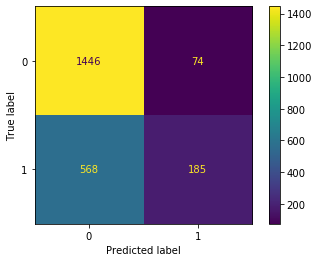

In [980]:
X_train_transformed = tfidf.fit_transform(X_train) #learning corpus of training data (holistic)
X_test_transformed = tfidf.transform(X_test) # new words only in test set won't impact

nb2.fit(X_train_transformed, y_train)

train_preds = nb2.predict(X_train_transformed)
test_preds = nb2.predict(X_test_transformed)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(nb,  X_train_transformed, y_train, cv=3, scoring='precision'))}")
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb2, X_test_transformed, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

### NB + TF-IDF2 (less word removal)

In [1004]:
# Instantiating the TF-IDF vectorizer
tfidf2 = TfidfVectorizer(max_df = .80, # removes words that appear in more than 80% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Trying Naive Bayes
nb3 = MultinomialNB()

Accuracy:0.7175538935327761
Precision:0.7142857142857143
Precision Mean Cross Val 3-Fold: 0.6948167298195197
F1 Score:0.36561264822134387


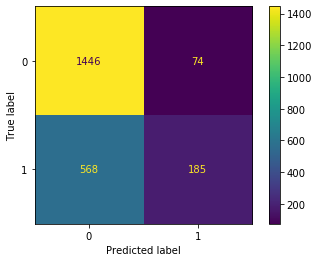

In [1005]:
X_train_transformed = tfidf2.fit_transform(X_train) #learning corpus of training data (holistic)
X_test_transformed = tfidf2.transform(X_test) # new words only in test set won't impact

nb3.fit(X_train_transformed, y_train)

train_preds = nb3.predict(X_train_transformed)
test_preds = nb3.predict(X_test_transformed)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(nb,  X_train_transformed, y_train, cv=3, scoring='precision'))}")
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb3, X_test_transformed, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()
# lessening word removal didn't do much

### RF?

In [1044]:
# Instantiating the TF-IDF vectorizer
tfidf3 = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Try RandomForest with class balance (not used in previous models)
rfc = RandomForestClassifier(class_weight='balanced')

Accuracy:0.7338319401671799
Precision:0.6434108527131783
Precision Mean Cross Val 3-Fold: 0.6328111526189262
F1 Score:0.5232466509062254


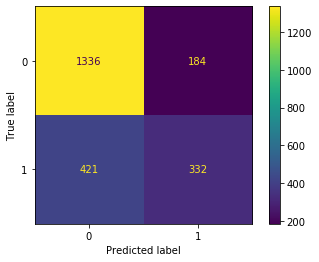

In [1045]:
X_train_transformed = tfidf3.fit_transform(X_train) #learning corpus of training data (holistic)
X_test_transformed = tfidf3.transform(X_test) # new words only in test set won't impact

rfc.fit(X_train_transformed, y_train)

train_preds = rfc.predict(X_train_transformed)
test_preds = rfc.predict(X_test_transformed)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(rfc,  X_train_transformed, y_train, cv=3, scoring='precision'))}")
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(rfc, X_test_transformed, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()
# higher accuracy .02, lower precision by .06

### SVC

In [1049]:
from sklearn.svm import SVC

In [1050]:
# Instantiating the TF-IDF vectorizer
tfidf4 = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Try CVS
svc = SVC()

In [1094]:
tfidf4.vocabulary_

{'hotpot': 2234,
 'hashphgoogle': 1794,
 'hashphmarissameyer': 1888,
 'hashphclevelandsteamer': 1706,
 'day': 944,
 'closer': 725,
 'owner': 2952,
 'ipad': 2370,
 'stoked': 3736,
 'thing': 3904,
 'getting': 1493,
 'final': 1347,
 'rtph': 3409,
 'menph': 2709,
 'line': 2548,
 'apple': 289,
 'store': 3743,
 'demo': 983,
 'unit': 4047,
 'pm': 3091,
 'hashphfb': 1769,
 'linkph': 2555,
 'listening': 2562,
 'google': 1528,
 'qa': 3225,
 'saying': 3449,
 'yelp': 4290,
 'service': 3514,
 'going': 1519,
 'die': 1019,
 'far': 1304,
 'interesting': 2345,
 'they': 3901,
 're': 3268,
 'developer': 1011,
 'awesome': 375,
 'event': 1233,
 'join': 2423,
 'league': 2508,
 'extraordinary': 1278,
 'hashphh4ckers': 1809,
 'able': 150,
 'content': 813,
 'sure': 3800,
 'heard': 2157,
 'right': 3376,
 'scene': 3458,
 'austin': 350,
 'sxsw': 3823,
 'popup': 3111,
 'shop': 3548,
 'arriving': 311,
 'hashphcnnmoneysxsw': 1714,
 'launch': 2494,
 'circle': 696,
 'later': 2488,
 'today': 3940,
 'context': 815,
 'ad

Accuracy:0.7483501979762428
Precision:0.7149643705463183
Precision Mean Cross Val 3-Fold: 0.6994046453301905
F1 Score:0.5127768313458262


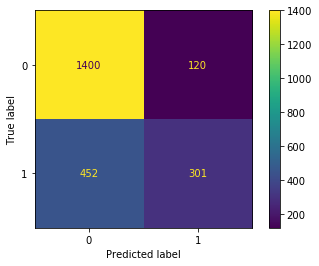

In [1051]:
X_train_transformed = tfidf4.fit_transform(X_train) #learning corpus of training data (holistic)
X_test_transformed = tfidf4.transform(X_test) # new words only in test set won't impact

svc.fit(X_train_transformed, y_train)

train_preds = svc.predict(X_train_transformed)
test_preds = svc.predict(X_test_transformed)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(svc,  X_train_transformed, y_train, cv=3, scoring='precision'))}")
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(svc, X_test_transformed, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()
# higher accuracy than NB + TF-IDF, same precision, slighty higher cross val .005

## Tuning SVM

### Took parameters from lesson
dsc-kernels-in-scikit-learn-lab/index.ipynb

In [1061]:
svc2 = SVC(C=1.0, kernel='linear', gamma='auto')

Accuracy:0.7355917289925209
Precision:0.6576763485477178
Precision Mean Cross Val 3-Fold: 0.6575309811679558
F1 Score:0.5133603238866398


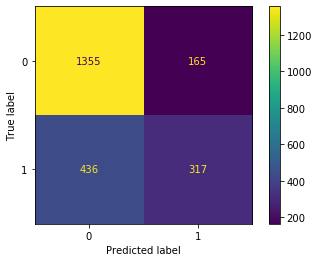

In [1062]:
X_train_transformed = tfidf4.fit_transform(X_train) #learning corpus of training data (holistic)
X_test_transformed = tfidf4.transform(X_test) # new words only in test set won't impact

svc2.fit(X_train_transformed, y_train)

train_preds = svc2.predict(X_train_transformed)
test_preds = svc2.predict(X_test_transformed)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(svc2,  X_train_transformed, y_train, cv=3, scoring='precision'))}")
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(svc2, X_test_transformed, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

In [1090]:
C_range = np.array([0.1, 1, 10])
gamma_range = np.array([0.1, 1, 100])
param_grid = dict(gamma=gamma_range, C=C_range)
clfs = []

# Create a loop that builds a model for each  combinations
for C in C_range:
    for gamma in gamma_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_train_transformed, y_train)
        clfs.append(clf)

In [1091]:
for clf in clfs:
    train_preds = clf.predict(X_train_transformed)
    test_preds = clf.predict(X_test_transformed)

    print(clf)
    print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
    print(f'Precision:{precision_score(y_test, test_preds)}')
    print(f'F1 Score:{f1_score(y_test, test_preds)}')
    print('----------')

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:0.6687197536295645
Precision:0.0
F1 Score:0.0
----------


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:0.6726792784865816
Precision:1.0
F1 Score:0.023622047244094488
----------
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:0.6687197536295645
Precision:0.0
F1 Score:0.0
----------
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:0.6924769027716674
Precision:0.8970588235294118
F1 Score:0.14859926918392202
----------
SVC(C=1.0, bre

# WINNING MODEL .69/89 - and well fit

- more balance in accuracy and precision when (C=1.0, gamma=1.0, random_state=42) --> .73/75
- class_weight = balanced actually hurts scores

In [1086]:
svc_tuned = SVC(C=1.0, gamma=0.1, random_state=42)

Train Scores
Accuracy:0.7085655617483133
Precision:0.9103448275862069
Precision Mean Cross Val 3-Fold: 0.8931048551611588
F1 Score:0.2099403578528827
--------
Test Scores
Accuracy:0.6924769027716674
Precision:0.8970588235294118
Precision Mean Cross Val 3-Fold: 0.8931048551611588
F1 Score:0.14859926918392202


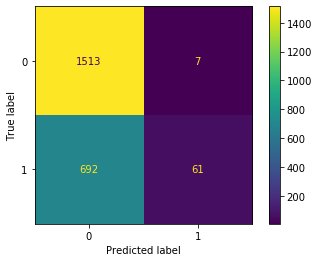

In [1093]:
X_train_transformed = tfidf4.fit_transform(X_train) #learning corpus of training data (holistic)
X_test_transformed = tfidf4.transform(X_test) # new words only in test set won't impact

svc_tuned.fit(X_train_transformed, y_train)

train_preds = svc_tuned.predict(X_train_transformed)
test_preds = svc_tuned.predict(X_test_transformed)

print ('Train Scores')
print(f'Accuracy:{accuracy_score(y_train, train_preds)}')
print(f'Precision:{precision_score(y_train, train_preds)}')
print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(svc_tuned, X_train_transformed, y_train, cv=3, scoring='precision'))}")
print(f'F1 Score:{f1_score(y_train, train_preds)}')
print ('--------')
print ('Test Scores')
print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(svc_tuned, X_train_transformed, y_train, cv=3, scoring='precision'))}")
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(svc_tuned, X_test_transformed, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()
# Highest precision, lower accuracy (but higher than a random guess)

### Word2Vec

In [989]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,target,clean_tweet,token_tweet,clean_token_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,0,menph 3g iphone 3 hrs tweeting hashphrise_aust...,"[menph, 3, g, iphone, 3, hr, tweeting, hashphr...",menph 3 g iphone 3 hr tweeting hashphrise_aust...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,1,menph know menph awesome ipadiphone app youll ...,"[menph, know, menph, awesome, ipadiphone, app,...",menph know menph awesome ipadiphone app you ll...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,1,menph wait hashphipad 2 sale hashphsxsw,"[menph, wait, hashphipad, 2, sale, hashphsxsw]",menph wait hashphipad 2 sale hashphsxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,0,menph hope years festival isnt crashy years ip...,"[menph, hope, year, festival, is, nt, crashy, ...",menph hope year festival is nt crashy year iph...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,1,menph great stuff fri hashphsxsw marissa mayer...,"[menph, great, stuff, fri, hashphsxsw, marissa...",menph great stuff fri hashphsxsw marissa mayer...


In [990]:
model = Word2Vec(df['token_tweet'], vector_size=100, window=5, min_count=1, workers=4)

In [991]:
model.train(df['token_tweet'], total_examples=model.corpus_count, epochs=10)

(765477, 1071170)

In [992]:
wv = model.wv

In [993]:
wv.most_similar('sxsw')

[('release', 0.8367705345153809),
 ('hashphaustin', 0.8241668343544006),
 ('hashphbjdproductions', 0.8132259249687195),
 ('hashphtechnology', 0.8112626075744629),
 ('get', 0.7958012223243713),
 ('begin', 0.7890344858169556),
 ('hashphphoto', 0.7888123393058777),
 ('revealed', 0.7886450290679932),
 ('stereo', 0.7823019027709961),
 ('slice', 0.7775318622589111)]

In [994]:
wv.most_similar('apple')

[('congress', 0.8858756422996521),
 ('6th', 0.8796737790107727),
 ('suddenly', 0.8774093389511108),
 ('sell', 0.8695181012153625),
 ('pop', 0.8678969144821167),
 ('temp', 0.8668717741966248),
 ('shakespeare', 0.8658519387245178),
 ('ipad2s', 0.863753616809845),
 ('bldg', 0.8595448732376099),
 ('lavaca', 0.8573155999183655)]

In [995]:
wv.most_similar('google')

[('nasdaq', 0.7533242106437683),
 ('vandaag', 0.7487692832946777),
 ('product', 0.7439689636230469),
 ('geen', 0.7418256402015686),
 ('myopia', 0.7367551326751709),
 ('say', 0.7360135316848755),
 ('linking', 0.734833300113678),
 ('strategy', 0.7333560585975647),
 ('announcing', 0.729672372341156),
 ('oreily', 0.7285059094429016)]

In [996]:
model2 = Word2Vec(df['token_tweet'], vector_size=100, window=2, min_count=450 , workers=4) 
# min count is 5% of total records
# window 2 because tweets are short

In [997]:
model2.train(df['token_tweet'], total_examples=model.corpus_count, epochs=10)

(60883, 1071170)

In [998]:
wv2 = model2.wv

In [1000]:
wv2.most_similar('sxsw')

[('austin', 0.952768862247467),
 ('popup', 0.8813835978507996),
 ('store', 0.8265151381492615),
 ('apple', 0.792104184627533),
 ('2', 0.7667823433876038),
 ('nt', 0.7379580736160278),
 ('ipad', 0.7048377990722656),
 ('linkph', 0.6424940228462219),
 ('hashphsxsw', 0.6212577819824219),
 ('rtph', 0.6184313893318176)]

In [1001]:
wv2.most_similar('apple')

[('austin', 0.9070360064506531),
 ('popup', 0.8843468427658081),
 ('sxsw', 0.792104184627533),
 ('2', 0.7625585794448853),
 ('ipad', 0.7132009863853455),
 ('store', 0.649097204208374),
 ('nt', 0.5862869620323181),
 ('app', 0.5541595816612244),
 ('linkph', 0.5017343163490295),
 ('iphone', 0.49785947799682617)]

In [1002]:
wv2.most_similar('google')

[('today', 0.9395736455917358),
 ('network', 0.9175278544425964),
 ('circle', 0.9071428775787354),
 ('social', 0.8838416934013367),
 ('launch', 0.8276165127754211),
 ('new', 0.8243567943572998),
 ('menph', 0.6194792985916138),
 ('iphone', 0.5834566354751587),
 ('linkph', 0.5696870684623718),
 ('rtph', 0.4935666620731354)]

### Glove

In [1015]:
df['tweet_text']

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9086    @mention Yup, but I don't have a third app yet...
9087                        Ipad everywhere. #SXSW {link}
9088    Wave, buzz... RT @mention We interrupt your re...
9089    Google's Zeiger, a physician never reported po...
9090    Some Verizon iPhone customers complained their...
Name: tweet_text, Length: 9091, dtype: object

In [1016]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,target,clean_tweet,token_tweet,clean_token_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,0,menph 3g iphone 3 hrs tweeting hashphrise_aust...,"[menph, 3, g, iphone, 3, hr, tweeting, hashphr...",menph 3 g iphone 3 hr tweeting hashphrise_aust...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,1,menph know menph awesome ipadiphone app youll ...,"[menph, know, menph, awesome, ipadiphone, app,...",menph know menph awesome ipadiphone app you ll...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,1,menph wait hashphipad 2 sale hashphsxsw,"[menph, wait, hashphipad, 2, sale, hashphsxsw]",menph wait hashphipad 2 sale hashphsxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,0,menph hope years festival isnt crashy years ip...,"[menph, hope, year, festival, is, nt, crashy, ...",menph hope year festival is nt crashy year iph...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,1,menph great stuff fri hashphsxsw marissa mayer...,"[menph, great, stuff, fri, hashphsxsw, marissa...",menph great stuff fri hashphsxsw marissa mayer...


In [1021]:
total_vocabulary = set(word for tweet in df['token_tweet'] for word in tweet)

In [1022]:
len(total_vocabulary)

9930

In [1023]:
glove = {}
with open('../data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [1024]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [1025]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [1026]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [1027]:
models = [('Naive Bayes', nb),
          ('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

In [1029]:
target = df['target']
data = df['token_tweet']

In [1047]:
scores = [(name, cross_val_score(model, data, target, cv=2, scoring='precision').mean()) for name, model, in models]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBacken

In [1048]:
scores

[('Naive Bayes', nan),
 ('Random Forest', 0.6337746411154612),
 ('Support Vector Machine', 0.7678571428571428),
 ('Logistic Regression', 0.5068274131806019)]

In [ ]:
# More on codealong

In [1034]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [1036]:
target = df['target']
y = pd.get_dummies(target).values

In [1037]:
tokenizer = text.Tokenizer(num_words=2500)
tokenizer.fit_on_texts(list(df['tweet_text']))
list_tokenized_headlines = tokenizer.texts_to_sequences(df['tweet_text'])
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

In [1038]:
model = Sequential()

In [1039]:
embedding_size = 128
model.add(Embedding(2500, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(41, activation='softmax'))

In [1040]:
model.compile(optimizer='adam', 
              metrics=['precision'])

In [1041]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         320000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                2

In [1042]:
# ⏰ This cell may take several minutes to run
model.fit(X_t, y, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3


ValueError: in user code:

    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/engine/training.py:830 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/engine/training.py:813 run_step  *
        outputs = model.train_step(data)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/engine/training.py:774 train_step  *
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:530 minimize  **
        return self.apply_gradients(grads_and_vars, name=name)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:630 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/utils.py:76 filter_empty_gradients
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['embedding/embeddings:0', 'lstm/lstm_cell/kernel:0', 'lstm/lstm_cell/recurrent_kernel:0', 'lstm/lstm_cell/bias:0', 'dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0'].


### MORE SPACY PLAY

In [ ]:
# Part 1 Fail

In [933]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [935]:
df.target.value_counts(normalize=True)

0    0.672423
1    0.327577
Name: target, dtype: float64

In [937]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [938]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [939]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [940]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [948]:
from sklearn.model_selection import train_test_split

X = df['tweet_text'] # the features we want to analyze
ylabels = df['target'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.33, random_state=42)

In [955]:
X

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9086    @mention Yup, but I don't have a third app yet...
9087                        Ipad everywhere. #SXSW {link}
9088    Wave, buzz... RT @mention We interrupt your re...
9089    Google's Zeiger, a physician never reported po...
9090    Some Verizon iPhone customers complained their...
Name: tweet_text, Length: 9091, dtype: object

In [951]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

In [952]:
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

In [954]:
X_train

2405    I really could use one of those tiny MacBook A...
5572    RT @mention Big night: Come party down with @m...
7020    @mention Only Google's disavowal of its planne...
621     Loved the honesty in Google's Marissa Mayer ke...
2126    @mention at #sxsw: &quot;apple comes up with c...
                              ...                        
5734    RT @mention For those #notatSXSW (or at #SXSW)...
5191    RT @mention &quot;the future of local is conte...
5390    RT @mention Android may be gaining market shar...
860     .@mention Love it. @mention @mention #sxsw: &q...
7270    Anyone know status of iPad 2s in Austin pop-up...
Name: tweet_text, Length: 6090, dtype: object

In [953]:
# model generation
pipe.fit(X_train,y_train)

ValueError: empty vocabulary; perhaps the documents only contain stop words